In [1]:
import os
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Input, BatchNormalization, Dropout
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
import random
import pickle
from tensorflow.python.framework.ops import disable_eager_execution
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from tensorflow.keras import mixed_precision

In [2]:
# set up tf enviroment
disable_eager_execution()

os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
#tf.config.optimizer.set_jit(True)
#set memory growth
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
#set precision piolicy
mixed_precision.set_global_policy(mixed_precision.Policy('mixed_float16')) #float32 optional

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: GeForce RTX 3080, compute capability 8.6


In [3]:
IMG_SIZE = 224
base_dir = "./ranzcr_clip_catheter_line_classification/"

train_df = pd.read_csv(os.path.join(base_dir, "train.csv"))
train_df.nunique()
train_df.head()
#3255 unique patients, We want to make sure that each patient's images do not appear in multiple folds to avoid data leakage

,StudyInstanceUID,ETT - Abnormal,ETT - Borderline,ETT - Normal,NGT - Abnormal,NGT - Borderline,NGT - Incompletely Imaged,NGT - Normal,CVC - Abnormal,CVC - Borderline,CVC - Normal,Swan Ganz Catheter Present,PatientID
0,1.2.826.0.1.3680043.8.498.26697628953273228189...,0,0,0,0,0,0,1,0,0,0,0,ec89415d1
1,1.2.826.0.1.3680043.8.498.46302891597398758759...,0,0,1,0,0,1,0,0,0,1,0,bf4c6da3c
2,1.2.826.0.1.3680043.8.498.23819260719748494858...,0,0,0,0,0,0,0,0,1,0,0,3fc1c97e5
3,1.2.826.0.1.3680043.8.498.68286643202323212801...,0,0,0,0,0,0,0,1,0,0,0,c31019814
4,1.2.826.0.1.3680043.8.498.10050203009225938259...,0,0,0,0,0,0,0,0,0,1,0,207685cd1


In [4]:
#some patients have over 100 images and some have only 1
train_df.PatientID.value_counts()

05029c63a    172
55073fece    167
26da0d5ad    148
8849382d0    130
34242119f    110
            ... 
a6dea776c      1
99d7dbb7c      1
5ea3e621c      1
b3c9675a9      1
ccc2585be      1
Name: PatientID, Length: 3255, dtype: int64

                  Malpositions  Number of Observations
0               ETT - Abnormal                      79
1             ETT - Borderline                    1138
2                 ETT - Normal                    7240
3               NGT - Abnormal                     279
4             NGT - Borderline                     529
5    NGT - Incompletely Imaged                    2748
6                 NGT - Normal                    4797
7               CVC - Abnormal                    3195
8             CVC - Borderline                    8460
9                 CVC - Normal                   21324
10  Swan Ganz Catheter Present                     830


<BarContainer object of 11 artists>

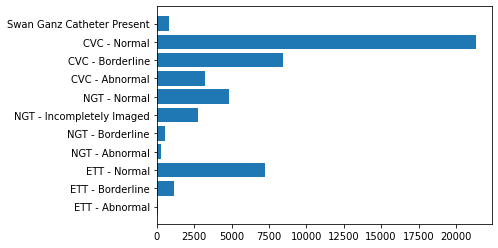

In [5]:
#plot label distrobution
categories = ['ETT - Abnormal', 'ETT - Borderline',
       'ETT - Normal', 'NGT - Abnormal', 'NGT - Borderline',
       'NGT - Incompletely Imaged', 'NGT - Normal', 'CVC - Abnormal',
       'CVC - Borderline', 'CVC - Normal','Swan Ganz Catheter Present']
categoryCounts = train_df[categories].sum(axis = 0).reset_index()
categoryCounts.columns = ['Malpositions', 'Number of Observations']
print(categoryCounts)
plt.barh(categoryCounts['Malpositions'], categoryCounts['Number of Observations'])


In [6]:
#load x and y data
xData = pickle.load(open("X.pickle", "rb"))
yData = pickle.load(open("y.pickle", "rb"))
folds = pickle.load(open("f.pickle", "rb"))

In [7]:
#scale to 0-1
Xtrain = np.array(xData)
Xtrain_scaled = []
for pic in tqdm(Xtrain):
    Xtrain_scaled.append(np.array(pic/255).astype(np.float32))
yData.astype(np.float32)

100%|██████████| 30083/30083 [00:11<00:00, 2616.14it/s]


array([ 5.,  1.,  1., ..., 86.,  1.,  1.], dtype=float32)

In [8]:
#split data
#Xtrain, Xtest, yTrain, yTest = train_test_split(Xtrain_scaled, ytrain, test_size=0.15, random_state=0, shuffle=True)
Xtrain, Xtest, Xvalidation, yTrain, yTest, yValidation = [],[],[],[],[],[]

for i in range(len(Xtrain_scaled)):
    if folds[i]==4:
        Xtest.append(Xtrain_scaled[i])
        yTest.append(yData[i])
    elif folds[i]==3:
        Xvalidation.append(Xtrain_scaled[i])
        yValidation.append(yData[i])
    else:
        Xtrain.append(Xtrain_scaled[i])
        yTrain.append(yData[i])

In [9]:
#reshape and make all lists numpy arrays
Xtrain = np.array(Xtrain).reshape((-1,IMG_SIZE,IMG_SIZE,1))
yTrain = np.array(yTrain)
Xtest = np.array(Xtest).reshape((-1,IMG_SIZE,IMG_SIZE,1))
yTest = np.array(yTest)
Xvalidation = np.array(Xvalidation).reshape((-1,IMG_SIZE,IMG_SIZE,1))
yValidation = np.array(yValidation)

print(len(Xtrain))
print(np.array(Xtrain).shape)
print(len(yTrain))
print(len(Xvalidation))
print(np.array(Xvalidation).shape)
print(len(yValidation))
print(len(Xtest))
print(np.array(Xtest).shape)
print(len(yTest))

17945
(17945, 224, 224, 1)
17945
6069
(6069, 224, 224, 1)
6069
6069
(6069, 224, 224, 1)
6069


In [10]:
input = Input(shape=(IMG_SIZE, IMG_SIZE, 1))
model = tf.keras.applications.EfficientNetB0(weights=None, input_tensor=input, classes=211, classifier_activation='sigmoid')

model.summary()
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = "adam", metrics = ['sparse_categorical_accuracy'])

checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

hist = model.fit(x=Xtrain, y=yTrain, epochs=30, batch_size=128, validation_data=(Xvalidation, yValidation), callbacks=[cp_callback])
#batchsize 128 = 70s, 32=270s, 64=150s, 96 = 100s

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 1)  3           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 1)  0           normalization[0][0]              
_____________________________________________________________________________________

c:\users\spencer\documents\ece9309\kagglecomp\venv\lib\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


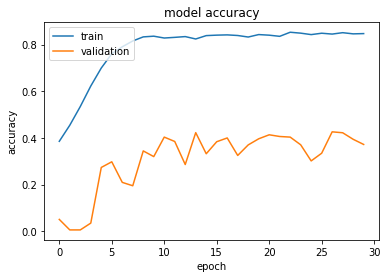

Test Loss:  6.622803257332345
Test Accuracy:  0.35425934


In [11]:
def plot_hist(hist):
    plt.plot(hist.history["sparse_categorical_accuracy"])
    plt.plot(hist.history["val_sparse_categorical_accuracy"])
    plt.title("Model Accuracy")
    plt.ylabel("Validation Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

plot_hist(hist)
score = model.evaluate(Xtest, yTest)
print("Test Loss: ", score[0])
print("Test Accuracy: ", score[1])

In [12]:
# Create model and load saved weights
#input = Input(shape=(IMG_SIZE, IMG_SIZE, 1))
#model = tf.keras.applications.EfficientNetB0(weights=checkpoint_path, input_tensor=input, classes=211, classifier_activation='sigmoid')


